# Imports

In [38]:
import time
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import os, sys
import seaborn as sns
import json
import sqlite3

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

In [39]:
ROOT_DATA_FOLDER = "../data"
API_DATE_FORMAT = "%Y-%m-%dT%H:%M:%SZ"
RANDOM_STATE = 42

# Functions

In [40]:
def pad(l: list, n: int, value=0):
    return l + [value] * (n - len(l))

In [41]:
def get_player_columns_name(feature_name):
    return [f"player_{i}_{feature_name}" for i in range(1, 13)]

In [42]:
# Shuffle teams so that half of the activities were won
def get_cols_name(player_range_start: int, player_range_end: int):
    return np.array(
        [[f"player_{i}_{stat}" for stat in STATS_NAME] for i in range(player_range_start, player_range_end)]).reshape(
        (player_range_end - player_range_start) * N_STATS)

def shuffle_winning_team(df):
    # Not optimal - renaming columns but the rvalue consume memory as well
    mid = len(df) // 2

    # First shuffle dataframe to ensure dates are shuffle as well
    df = df.sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)

    player_cols_team_A = get_cols_name(1, 7)
    player_cols_team_B = get_cols_name(7, 13)
    tmp_cols = [f"tmp_{i}" for i in range(6*N_STATS)]

    # False positive warning (see https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas)
    df.loc[:mid] = (df.loc[:mid].rename(columns={player_cols_team_A[i]: tmp_cols[i] for i in range(len(player_cols_team_A))})
                                    .rename(columns={player_cols_team_B[i]: player_cols_team_A[i] for i in range(len(player_cols_team_A))})
                                    .rename(columns={tmp_cols[i]: player_cols_team_B[i] for i in range(len(player_cols_team_A))}))\
                                    [df.columns]  # reorder columns
    df.loc[:mid, "winner"] = [1 for i in range(mid + 1)]
    return df

# Load data

In [43]:
%%time
train = pd.read_csv(os.path.join(ROOT_DATA_FOLDER, "train.csv"))
train["period"] = pd.to_datetime(train["period"], format="%Y-%m-%d %H:%M:%S")
train

CPU times: total: 14.5 s
Wall time: 15.7 s


,player_1_activities_entered,player_1_combat_rating,player_1_kills_pga,player_1_assists_pga,player_1_deaths_pga,player_1_score_pga,player_1_win_ratio,player_1_kd,player_1_kda,player_2_activities_entered,...,player_12_assists_pga,player_12_deaths_pga,player_12_score_pga,player_12_win_ratio,player_12_kd,player_12_kda,winner,mode,period,instance_id
0,261.0,168.135969,8.103448,3.252874,8.176245,5.896552,0.444444,0.991097,1.388941,2417.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,71,2017-09-05 23:32:24,1885169
1,390.0,161.895219,11.684615,3.951282,8.828205,15.935897,0.551282,1.323555,1.771130,2417.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,71,2017-09-05 23:42:27,2024057
2,390.0,161.895219,11.684615,3.951282,8.828205,15.935897,0.551282,1.323555,1.771130,2417.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,73,2017-09-05 23:53:01,2159868
3,390.0,161.895219,11.684615,3.951282,8.828205,15.935897,0.551282,1.323555,1.771130,2417.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,73,2017-09-06 00:04:05,2269987
4,17.0,130.364239,10.176471,5.176471,10.764706,15.411765,0.352941,0.945355,1.426230,49.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,73,2017-09-06 05:42:33,7875392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024538,33121.0,151.767243,13.157091,2.760122,7.054618,18.008031,0.597959,1.865032,2.256283,4026.0,...,3.380557,8.950066,23.629230,0.603351,1.693500,2.071213,0.0,71,2022-12-08 18:11:22,12018990154
1024539,205.0,106.204519,9.434146,3.965854,7.668293,12.492683,0.497561,1.230280,1.747455,69.0,...,3.130886,8.006385,16.950519,0.374302,0.989833,1.380881,0.0,73,2022-12-08 18:20:09,12019036307
1024540,5810.0,158.251602,14.374355,4.447332,9.278141,27.070224,0.481239,1.549271,2.028605,1693.0,...,3.800287,9.218901,17.859679,0.346038,1.059581,1.471809,0.0,71,2022-12-08 18:29:49,12019094299
1024541,33121.0,151.767243,13.157091,2.760122,7.054618,18.008031,0.597959,1.865032,2.256283,799.0,...,3.353251,9.996485,20.509666,0.471002,0.899965,1.235408,0.0,88,2022-12-08 16:59:30,12019833328


In [44]:
train["winner"].value_counts()

0.0    1024543
Name: winner, dtype: int64

# Preprocessing

In [45]:
STATS_NAME = ["activities_entered", "combat_rating", "kills_pga", "assists_pga", "deaths_pga", "score_pga", "win_ratio", "kd", "kda"]
N_STATS = len(STATS_NAME)
PLAYERS_COLUMNS = np.array([[f"player_{i}_{stat}" for stat in STATS_NAME] for i in range(1, 13)]).reshape(12 * N_STATS)

In [46]:
# Select rows without stats missing
req = [f"(train['{col}'] > -0.5)" for col in PLAYERS_COLUMNS]
req = " & ".join(req)
train = train[eval(req)]  # hey, it's not stupid if it works
train.reset_index(inplace=True, drop=True)
train

,player_1_activities_entered,player_1_combat_rating,player_1_kills_pga,player_1_assists_pga,player_1_deaths_pga,player_1_score_pga,player_1_win_ratio,player_1_kd,player_1_kda,player_2_activities_entered,...,player_12_assists_pga,player_12_deaths_pga,player_12_score_pga,player_12_win_ratio,player_12_kd,player_12_kda,winner,mode,period,instance_id
0,261.0,168.135969,8.103448,3.252874,8.176245,5.896552,0.444444,0.991097,1.388941,2417.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,71,2017-09-05 23:32:24,1885169
1,390.0,161.895219,11.684615,3.951282,8.828205,15.935897,0.551282,1.323555,1.771130,2417.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,71,2017-09-05 23:42:27,2024057
2,390.0,161.895219,11.684615,3.951282,8.828205,15.935897,0.551282,1.323555,1.771130,2417.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,73,2017-09-05 23:53:01,2159868
3,17.0,130.364239,10.176471,5.176471,10.764706,15.411765,0.352941,0.945355,1.426230,49.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,73,2017-09-06 05:42:33,7875392
4,124.0,162.975152,11.685484,3.766129,9.895161,17.645161,0.564516,1.180929,1.561532,547.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,73,2017-09-06 09:14:55,12789762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895418,940.0,177.178008,16.147872,3.550000,9.417021,31.580851,0.522340,1.714754,2.091731,614.0,...,2.659341,9.806593,17.496703,0.509890,1.425146,1.696325,0.0,71,2022-12-08 17:58:28,12018945431
895419,33121.0,151.767243,13.157091,2.760122,7.054618,18.008031,0.597959,1.865032,2.256283,4026.0,...,3.380557,8.950066,23.629230,0.603351,1.693500,2.071213,0.0,71,2022-12-08 18:11:22,12018990154
895420,205.0,106.204519,9.434146,3.965854,7.668293,12.492683,0.497561,1.230280,1.747455,69.0,...,3.130886,8.006385,16.950519,0.374302,0.989833,1.380881,0.0,73,2022-12-08 18:20:09,12019036307
895421,33121.0,151.767243,13.157091,2.760122,7.054618,18.008031,0.597959,1.865032,2.256283,799.0,...,3.353251,9.996485,20.509666,0.471002,0.899965,1.235408,0.0,88,2022-12-08 16:59:30,12019833328


 # Test

In [ ]:
team_A_columns = []
for i in range(1, 7):
    for stat in STATS_NAME:
        team_A_columns.append(f"player_{i}_{stat}")

X = train[team_A_columns]

pca = PCA(n_components=N_STATS)

In [ ]:
pca.fit(X)

PCA(n_components=9)

In [ ]:
a = pca.transform(X)
b = pca.transform(X)

In [ ]:
a.shape

(432560, 9)

In [ ]:
np.concatenate((a, b, [[0] for i in range(432560)]), axis=1).shape

(432560, 19)

# Data selection

Gamemodes:
1. 73 = control quickplay
2. 84 = osiris
3. 71 = clash quickplay
4. 37 = survival

In [72]:
sel = train

# sel = sel.drop(columns=get_player_columns_name("activities_entered"))
sel = sel[sel["mode"] == 73]
sel = sel[sel.period < datetime(year=2022, month=1, day=1)]
# sel = sel[get_player_columns_name("combat_rating")]
# sel = sel[get_player_columns_name("kd") + 
#           get_player_columns_name("win_ratio") + 
#           ["winner", "period", "mode", "instance_id"]]

sel = shuffle_winning_team(sel)

sel

,player_1_activities_entered,player_1_combat_rating,player_1_kills_pga,player_1_assists_pga,player_1_deaths_pga,player_1_score_pga,player_1_win_ratio,player_1_kd,player_1_kda,player_2_activities_entered,...,player_12_assists_pga,player_12_deaths_pga,player_12_score_pga,player_12_win_ratio,player_12_kd,player_12_kda,winner,mode,period,instance_id
0,2310.0,123.951145,9.732035,3.724242,8.127273,13.992641,0.535498,1.197454,1.655694,296.0,...,1.333333,12.333333,6.666667,0.333333,0.162162,0.270270,1.0,73,2021-11-28 20:13:37,9662113161
1,3172.0,150.251895,9.945460,2.408575,6.020807,11.230769,0.641866,1.651848,2.051890,1039.0,...,3.483673,10.929592,20.627806,0.384184,1.046378,1.365115,1.0,73,2020-12-05 22:11:27,7468845040
2,618.0,154.624202,13.783172,4.281553,10.703883,28.556634,0.529126,1.287680,1.687680,1788.0,...,2.704047,8.310287,13.200675,0.391231,0.754464,1.079850,1.0,73,2020-10-08 20:23:49,7000652752
3,1758.0,127.213594,11.014221,3.445961,8.771900,12.751991,0.520478,1.255625,1.648466,3468.0,...,3.041958,12.181818,12.825175,0.475524,0.309414,0.559127,1.0,73,2021-04-26 23:18:35,8362034483
4,5500.0,174.151722,15.347455,4.041091,9.335273,31.632909,0.438182,1.644029,2.076913,27.0,...,4.548552,10.628620,30.412266,0.514480,1.292675,1.720628,1.0,73,2021-05-09 19:43:10,8410231794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85537,290.0,123.158212,9.127586,3.303448,8.434483,19.796552,0.568966,1.082175,1.473835,4101.0,...,3.565676,9.652924,16.040268,0.444871,1.098331,1.467720,0.0,73,2019-01-15 07:03:23,3467221164
85538,1815.0,141.456115,11.634160,3.861157,9.012672,19.710744,0.506336,1.290867,1.719281,655.0,...,1.916230,10.445026,7.649215,0.486911,0.212531,0.395990,0.0,73,2021-03-09 21:21:22,8126987533
85539,3737.0,173.568412,16.798769,4.433235,10.033182,26.890019,0.540273,1.674321,2.116179,4052.0,...,2.164384,8.068493,4.390411,0.356164,0.448217,0.716469,0.0,73,2021-09-25 19:20:44,9311637131
85540,764.0,158.704299,13.045812,3.943717,7.836387,25.520942,0.586387,1.664774,2.168031,244.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,73,2017-11-19 22:31:43,1054785712


In [73]:
sel["winner"].value_counts()

1.0    42772
0.0    42770
Name: winner, dtype: int64

In [74]:
X = sel.drop(columns=["winner", "period", "instance_id"])
Y = sel["winner"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE, stratify=Y)

In [ ]:
# Keep period
X = sel.drop(columns=["winner"])
Y = sel["winner"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE, stratify=Y)

X_train_period = X_train["period"]
X_test_period = X_test["period"]
X_train.drop(columns=["period"], inplace=True)
X_test.drop(columns=["period"], inplace=True)

In [ ]:
# split train with date
max_train_date = datetime(year=2022, month=1, day=1)

X_train = sel[train.period < max_train_date]
y_train = X_train["winner"]
X_train.drop(columns=["winner", "period"], inplace=True)

X_test = sel[train.period >= max_train_date]
y_test = X_test["winner"]
X_test.drop(columns=["winner", "period"], inplace=True)

<ipython-input-26-c3501dbf63d0>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = sel[train.period < max_train_date]
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-26-c3501dbf63d0>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test = sel[train.period >= max_train_date]


In [ ]:
# PCA test
X = sel.drop(columns=["winner", "period", "instance_id"])
Y = sel["winner"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE, stratify=Y)

team_A_columns = []
for i in range(1, 7):
    for stat in STATS_NAME:
        team_A_columns.append(f"player_{i}_{stat}")

team_B_columns = []
for i in range(1, 7):
    for stat in STATS_NAME:
        team_B_columns.append(f"player_{i}_{stat}")

pca = PCA(n_components=N_STATS)
pca.fit(X_train[team_A_columns])

X_train = np.concatenate((pca.transform(X_train[team_A_columns]),
                          pca.transform(X_train[team_B_columns])), axis=1)
X_test = np.concatenate((pca.transform(X_test[team_A_columns]),
                         pca.transform(X_test[team_B_columns])), axis=1)

In [ ]:
# Mean of every stat per team
X = sel.drop(columns=["winner", "period", "instance_id"])
Y = sel["winner"]

TEAM_COLUMNS = [f"team_A_{stat}" for stat in STATS_NAME] + [f"team_B_{stat}" for stat in STATS_NAME]
for i in range(len(STATS_NAME)):
    col = TEAM_COLUMNS[i]
    stat = STATS_NAME[i]
    c = [f"player_{k}_{stat}" for k in range(1, 7)]
    X[col] = X.loc[:, c].mean(axis=1)
for i in range(len(STATS_NAME)):
    col = TEAM_COLUMNS[i+N_STATS]
    stat = STATS_NAME[i]
    c = [f"player_{k}_{stat}" for k in range(7, 13)]
    X[col] = X.loc[:, c].mean(axis=1)
X.drop(columns=PLAYERS_COLUMNS, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE, stratify=Y)

# Catboost

In [75]:
%%time
clf = CatBoostClassifier(verbose=False, task_type='GPU', random_state=RANDOM_STATE)
clf.fit(X_train, y_train, cat_features=["mode"])

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

probs = clf.predict_proba(X_test).max(axis=1)
confusion_matrix_mean_prob = np.array([[probs[np.where((y_test == y_pred) & (y_test == 0))].mean(), probs[np.where((y_pred == 1) & (y_test == 0))].mean()],
                                       [probs[np.where((y_pred == 0) & (y_test == 1))].mean(), probs[np.where((y_test == y_pred) & (y_test == 1))].mean()]])
print("Mean proba for each section of the confusion matrix:")
print(confusion_matrix_mean_prob)

Accuracy: 0.7064645598721895
F1-score: 0.7066246056782334
[[9058 3773]
 [3760 9072]]
Mean proba for each section of the confusion matrix:
[[0.71853743 0.63589884]
 [0.634087   0.71814287]]
CPU times: total: 19.7 s
Wall time: 17.4 s


In [53]:
level = 0.7

level_idx = np.where(probs > level)[0]
y_level = y_pred[level_idx]
y_true = y_test.values[level_idx]

print("Accuracy:", accuracy_score(y_true, y_level))
print("F1-score:", f1_score(y_true, y_level))

print("Total tests: ", len(y_test))
print("Number of predictions: ", len(level_idx))
print("Number of uncertain predictions: ", len(y_test) - len(level_idx))
print("Loss predictions: ", 1-(len(level_idx) / len(y_test)))

print(confusion_matrix(y_true, y_level))

Accuracy: 0.8488988580750407
F1-score: 0.8483525479227779
Total tests:  88562
Number of predictions:  44136
Number of uncertain predictions:  44426
Loss predictions:  0.5016372710643391
[[18813  3333]
 [ 3336 18654]]


In [76]:
importances = pd.DataFrame()
importances["feature"] = X_test.columns
importances["importance"] = clf.feature_importances_
importances.sort_values(by=["importance"], ascending=False, inplace=True)
importances

,feature,importance
51,player_6_win_ratio,5.590670
105,player_12_win_ratio,5.130185
60,player_7_win_ratio,3.838154
6,player_1_win_ratio,3.741160
42,player_5_win_ratio,3.394585
...,...,...
68,player_8_score_pga,0.095843
46,player_6_combat_rating,0.083657
23,player_3_score_pga,0.075295
93,player_11_assists_pga,0.051652


<AxesSubplot:xlabel='feature'>

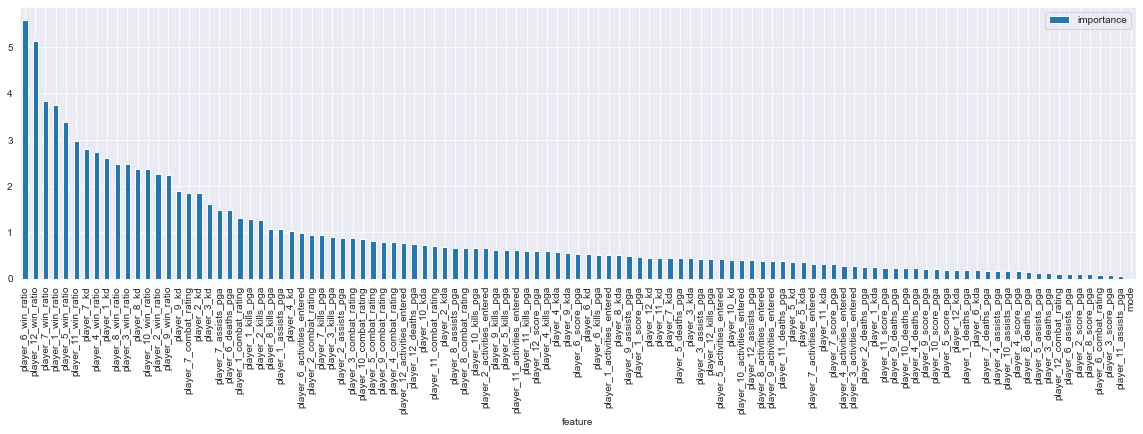

In [77]:
importances.plot(kind="bar", x="feature", y="importance", figsize=(20, 5))

In [ ]:
class CustomCatBoostClassifier(CatBoostClassifier):
    def fit(self, X, y=None, **fit_params):
        return super().fit(
            X,
            y=y,
            cat_features=["mode"],
            **fit_params
            )

pipeline = make_pipeline(CustomCatBoostClassifier(verbose=False, task_type='GPU', random_state=RANDOM_STATE))
acc_scores = cross_val_score(pipeline, X, Y, cv=3, scoring="accuracy", n_jobs=-1)
print(f"Mean acc = {acc_scores.mean()}, Std acc = {acc_scores.std()}")
print(pipeline)

Mean acc = 0.7354318113840592, Std acc = 0.0006893767656310474
Pipeline(steps=[('customcatboostclassifier',
                 <__main__.CustomCatBoostClassifier object at 0x7f974ddf0b20>)])


# Random forest

In [ ]:
pipeline = make_pipeline(RandomForestClassifier())
acc_scores = cross_val_score(pipeline, X, Y, cv=4, scoring="accuracy", n_jobs=-1)
print(f"Mean acc = {acc_scores.mean()}, Std acc = {acc_scores.std()}")
print(pipeline)

Mean acc = 0.7165999548704958, Std acc = 0.0007046547932585566
Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())])


# Deep learning model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
X_train.drop(columns=["mode"], inplace=True)
X_test.drop(columns=["mode"], inplace=True)

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(len(X_train.columns),)))
model.add(layers.Dense(len(X_train.columns), activation="relu"))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(12, activation="relu"))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

clf = KerasClassifier(model=model, epochs=25, batch_size=25)

pipeline = make_pipeline(StandardScaler(), clf)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 108)               11772     
                                                                 
 dropout (Dropout)           (None, 108)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                1308      
                                                                 
 dropout_1 (Dropout)         (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 13,093
Trainable params: 13,093
Non-trainable params: 0
_________________________________________________________________


In [ ]:
pipeline.fit(X_train, y_train)

Epoch 1/25
6527/6527 [==============================] - 22s 3ms/step - loss: 0.4550 - accuracy: 0.7847
Epoch 2/25
6527/6527 [==============================] - 19s 3ms/step - loss: 0.4456 - accuracy: 0.7895
Epoch 3/25
6527/6527 [==============================] - 19s 3ms/step - loss: 0.4441 - accuracy: 0.7894
Epoch 4/25
6527/6527 [==============================] - 19s 3ms/step - loss: 0.4432 - accuracy: 0.7901
Epoch 5/25
6527/6527 [==============================] - 19s 3ms/step - loss: 0.4417 - accuracy: 0.7908
Epoch 6/25
6527/6527 [==============================] - 18s 3ms/step - loss: 0.4412 - accuracy: 0.7918
Epoch 7/25
6527/6527 [==============================] - 19s 3ms/step - loss: 0.4403 - accuracy: 0.7920
Epoch 8/25
6527/6527 [==============================] - 19s 3ms/step - loss: 0.4399 - accuracy: 0.7920
Epoch 9/25
6527/6527 [==============================] - 19s 3ms/step - loss: 0.4390 - accuracy: 0.7923
Epoch 10/25
6527/6527 [==============================] - 19s 3ms/step - l

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kerasclassifier',
                 KerasClassifier(batch_size=25, epochs=25, model=<keras.engine.sequential.Sequential object at 0x7f88fb582340>))])

In [ ]:
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(pipeline)

2798/2798 [==============================] - 4s 1ms/step
Accuracy: 0.7870411417294685
F1-score: 0.7866047631330065
[[27590  7374]
 [ 7518 27447]]
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kerasclassifier',
                 KerasClassifier(batch_size=25, epochs=25, model=<keras.engine.sequential.Sequential object at 0x7f88fb582340>))])
